In [33]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
from cuml.manifold import TSNE as cu_TSNE
from cuml.manifold import UMAP as cu_UMAP
from sklearn.manifold import TSNE as sk_TSNE
from umap import UMAP as sk_UMAP
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import trustworthiness

A few settings to make the plots look the way I want them to

In [2]:
sns.set(rc={'figure.figsize': (7, 7)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

Read the data

In [3]:
df = pd.read_csv("chembl_drugs.smi",sep=" ",header=None)

In [4]:
df.columns = ["SMILES","Name"]

In [5]:
df.shape

(1495, 2)

Define a function to generate fingerprints with the RDKit

In [6]:
def fp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fp_list.append(fp_as_array(mol,n_bits))
    return fp_list

def fp_as_array(mol,n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), np.int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

Generate fingerprints

In [7]:
fp_list = fp_list_from_smiles_list(df.SMILES,512)

Add the fingerprints to the dataframe

In [8]:
df['fp'] = fp_list

In [9]:
df.head()

,SMILES,Name,fp
0,Br.CC(NC(C)(C)C)C(=O)c1cccc(Cl)c1,675686,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,Br.Cc1ccc(Sc2ccccc2N3CCNCC3)c(C)c1,1379657,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,Br.CN(C)CCCC1(OCc2cc(ccc12)C#N)c3ccc(F)cc3,674732,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Br.CN1CCC[C@@H]1Cc2c[nH]c3ccc(CCS(=O)(=O)c4ccc...,674954,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Br.COc1ccc2CN(C)CC[C@@]34C=C[C@H](O)C[C@@H]3Oc...,443255,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Run TSNE with the scikit-learn

sk_tsne = sk_TSNE(n_components=2, method='barnes_hut', n_jobs=-1,random_state=23)

In [11]:
desc = np.array(list(df.fp))
%time sk_embedding = sk_tsne.fit_transform(desc)

CPU times: user 47.3 s, sys: 1.82 s, total: 49.1 s
Wall time: 6.35 s


In [12]:
sk_trust = trustworthiness(desc,sk_embedding)
sk_trust

0.8760228783233959

Run TSNE with RAPIDS

In [13]:
cu_tsne = cu_TSNE(n_components = 2, method = 'barnes_hut',random_state=23)

In [14]:
desc = np.array(list(df.fp))
%time cu_embedding = cu_tsne.fit_transform(desc)

CPU times: user 444 ms, sys: 588 ms, total: 1.03 s
Wall time: 1.03 s


In [15]:
cu_trust = trustworthiness(desc,cu_embedding)
cu_trust

0.7762535958237838

Combine the scikit-learn and RAPIDS results so that we can compare

In [56]:
sk_df = pd.DataFrame(sk_embedding,columns=["X","Y"])
sk_df['Method'] = "sklearn"
cu_df = pd.DataFrame(cu_embedding,columns=["X","Y"])
cu_df["Method"] = "rapids"
tsne_combo_df = sk_df.append(cu_df)

Plot the comparison

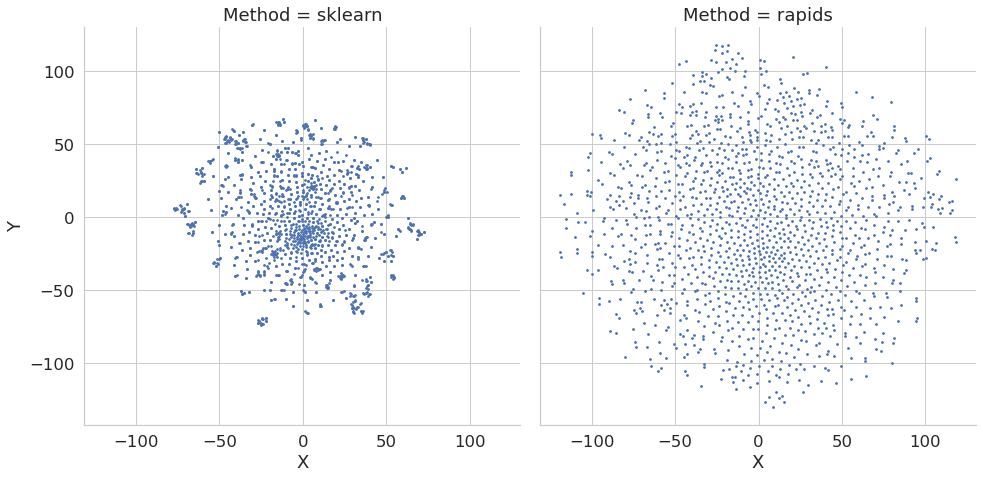

In [57]:
g = sns.FacetGrid(tsne_combo_df, col="Method",height=7)
g.map(plt.scatter, "X", "Y",s=3)

Generate a map with UMAP

In [58]:
n_neighbors = 4
sk_umap = sk_UMAP(n_neighbors=n_neighbors, min_dist=0.1, verbose=False)

In [59]:
%time sk_ut = sk_umap.fit_transform(desc)

CPU times: user 9.86 s, sys: 168 ms, total: 10 s
Wall time: 4.24 s


In [60]:
n_neighbors = 4
cu_umap = cu_UMAP(n_neighbors=n_neighbors, min_dist=0.1, verbose=False)

In [61]:
%time cu_ut = cu_umap.fit_transform(desc)

CPU times: user 24 ms, sys: 148 ms, total: 172 ms
Wall time: 173 ms


In [62]:
trustworthiness(desc,cu_ut)

0.8774115016879849

Plot the UMAP transformed data

In [63]:
sk_df = pd.DataFrame(sk_ut,columns=["X","Y"])
sk_df['Method'] = "sklearn"
cu_df = pd.DataFrame(cu_ut,columns=["X","Y"])
cu_df["Method"] = "rapids"
umap_combo_df = sk_df.append(cu_df)

Plot the comparison the scikit-learn and RAPIDS maps

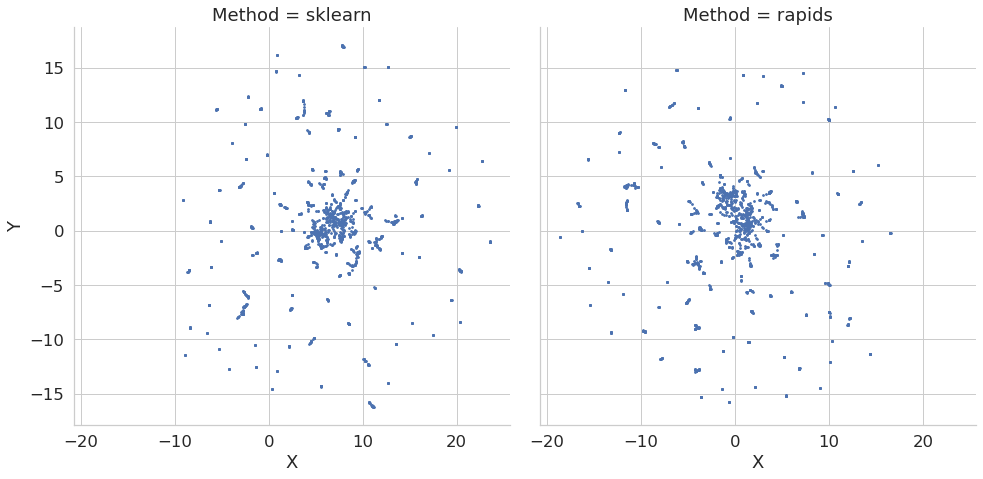

In [81]:
g = sns.FacetGrid(umap_combo_df, col="Method",height=7)
g.map(plt.scatter, "X", "Y",s=3)

Evaluate trustworthiness as a function of the number of neighbors

In [83]:
umap_nbr_df = pd.DataFrame()
nbr_trust_lst = []
for i in tqdm(range(2,10)):
    n_neighbors = i
    umap = cu_UMAP(n_neighbors=n_neighbors, min_dist=0.01, verbose=False)
    ut = umap.fit_transform(desc)
    nbr_trust_lst.append([i,trustworthiness(desc,ut)])
    tmp_df = pd.DataFrame(ut,columns=["X","Y"])
    tmp_df["nbrs"] = i
    umap_nbr_df = umap_nbr_df.append(tmp_df)

Plot trustworthiness as a function of the number of neighbors

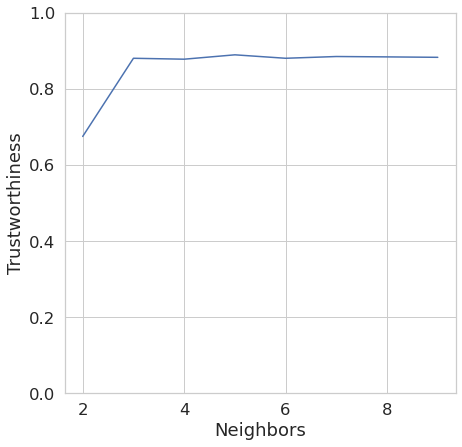

In [76]:
x = np.array(nbr_trust_lst)[:,0]
y = np.array(nbr_trust_lst)[:,1]
ax = sns.lineplot(x,y)
_ = ax.set(xlabel="Neighbors",ylabel="Trustworthiness",ylim=[0,1])

Plot maps for number of neighbors between 2 and 9

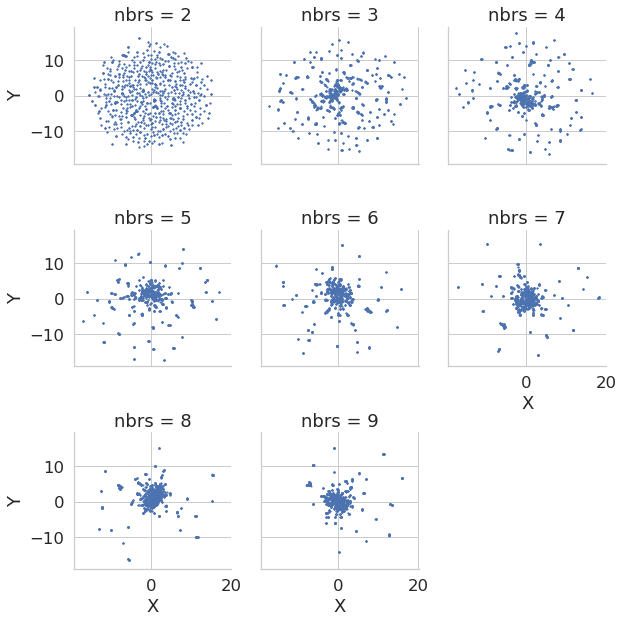

In [77]:
g = sns.FacetGrid(umap_nbr_df,col="nbrs",col_wrap=3)
g.map(plt.scatter, "X", "Y",s=1)

Evaluate trustworthiness as a function of minimum distance

In [78]:
umap_dist_df = pd.DataFrame()
md_trust_lst = []
for i in tqdm(np.arange(0.1,1,0.1)):
    n_neighbors = 4
    umap = cu_UMAP(n_neighbors=n_neighbors, min_dist=i, verbose=False)
    ut = umap.fit_transform(desc)
    md_trust_lst.append([i,trustworthiness(desc,ut)])
    tmp_df = pd.DataFrame(ut,columns=["X","Y"])
    tmp_df["min_dist"] = f"{i:.2f}"
    umap_dist_df = umap_dist_df.append(tmp_df)

Plot trustworthiness as a function of minimum distance

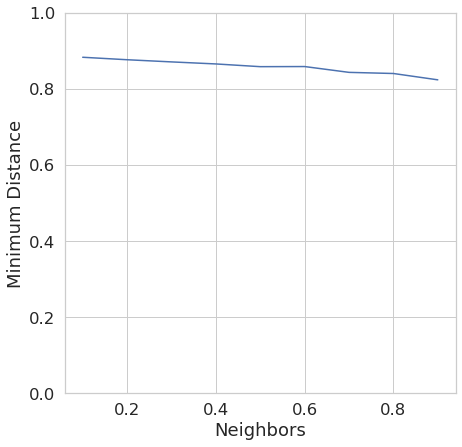

In [84]:
x = np.array(md_trust_lst)[:,0]
y = np.array(md_trust_lst)[:,1]
ax = sns.lineplot(x,y)
_ = ax.set(xlabel="Neighbors",ylabel="Minimum Distance",ylim=[0,1])

Plot maps for minimum distance between 0.1 and 0.9

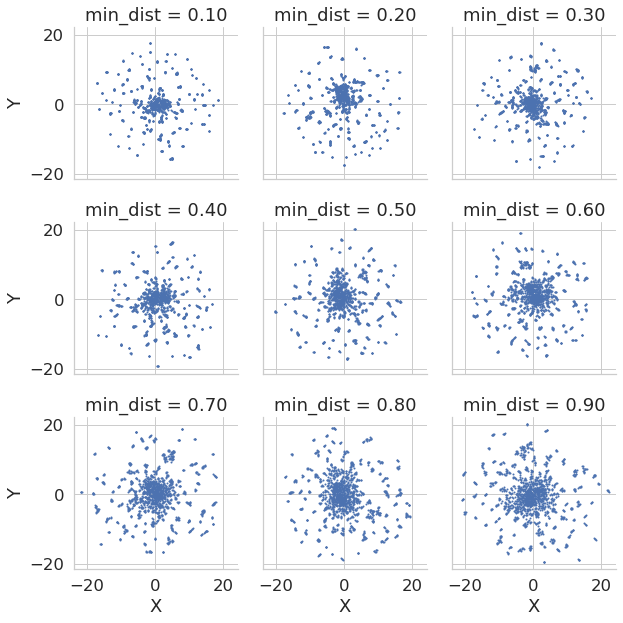

In [80]:
g = sns.FacetGrid(umap_dist_df,col="min_dist",col_wrap=3)
g.map(plt.scatter, "X", "Y",s=1)